In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tf_layers.layers import DenseLayer, LSTMLayer, add_implied_layers
from tf_layers.models import NN
from tf_layers.tf_utils import tf_init, n_model_parameters
from computer_vision.vqa.vqa_utils import load_data, generator, create_predictions_file
import pickle
import json

config = tf_init()

%matplotlib inline

/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# VQA Improvements
Submit results [here][submission].

[submission]: https://competitions.codalab.org/competitions/6991#participate-submit_results

## Image Aug

Compute mean and variance (for each "channel"?) from the train set. Store these somewhere and then use them to scale the image features. Then figure out a reasonable level of noise to add.

In [90]:
# see here for derivation of computing mean + variance from batches:
# https://stats.stackexchange.com/questions/43159/how-to-calculate-pooled-variance-of-two-groups-given-known-group-variances-mean

train_dir = '/cluster/nhunt/img_features/train/'

batch_means = []
batch_variances = []
batch_n_samples = []

for file in [f'{train_dir}/{f}' for f in os.listdir(train_dir)]:
    features = np.load(file)
    batch_means.append(features.mean(axis=(0, 1, 2)))
    batch_variances.append(features.var(axis=(0, 1, 2)))
    batch_n_samples.append(len(features))

batch_n_samples = np.array(batch_n_samples).reshape(-1, 1)
batch_means = np.stack(batch_means)
batch_variances = np.stack(batch_variances)

means = (batch_n_samples * batch_means).sum(axis=0) / (batch_n_samples.sum())
variances = (batch_n_samples * (batch_variances + batch_means ** 2)).sum(axis=0) / (batch_n_samples.sum()) - means ** 2

# to fit image shapes
means = means.reshape(1, 1, 1, -1)
variances = variances.reshape(1, 1, 1, -1)

with open('data/train/mean.npy', 'wb') as f:
    np.save(f, means)

with open('data/train/std.npy', 'wb') as f:
    np.save(f, np.sqrt(variances))

## QA Aug

In [10]:
qa = pd.read_hdf('data/train/qa.h5')
qa.head()

,img_path,answer,choices,question,objects,scene_type
0,data/train/images/abstract_v002_train2015_0000...,monkey bars,"[get warm, yes, playful, pug, red, fitness sys...",how is the equipments with bars called,"[[Doll02, 289, 242, 2, 1, -1], [sun, 594, 64, ...",Park-XinleiSubset
1,data/train/images/abstract_v002_train2015_0000...,no,"[1, csi, real, n, red, solid, blocks and car, ...",is the bench a toy,"[[Doll02, 289, 242, 2, 1, -1], [sun, 594, 64, ...",Park-XinleiSubset
2,data/train/images/abstract_v002_train2015_0000...,tan,"[1, 3, brown, wildlife, not having tv, yellow,...",what color is the ladies pants,"[[Doll02, 289, 242, 2, 1, -1], [sun, 594, 64, ...",Park-XinleiSubset
3,data/train/images/abstract_v002_train2015_0000...,no,"[sweet, yellow, what's neighbor, white, 4, blu...",is that grandmas pet rat,"[[Doll08, 585, 205, 2, 0, -1], [Rat, 196, 364,...",Living-XinleiSubset
4,data/train/images/abstract_v002_train2015_0000...,yes,"[1, 3, idk, no, 2, red, skinny, blue, yes, hin...",is the woman on the couch sporting white hair,"[[Doll08, 585, 205, 2, 0, -1], [Rat, 196, 364,...",Living-XinleiSubset


In [19]:
min_n_objects = 6

# for i in range(len(qa)):
i = 0
sample = qa.iloc[i]
sample

img_path      data/train/images/abstract_v002_train2015_0000...
answer                                              monkey bars
choices       [get warm, yes, playful, pug, red, fitness sys...
question                 how is the equipments with bars called
objects       [[Doll02, 289, 242, 2, 1, -1], [sun, 594, 64, ...
scene_type                                    Park-XinleiSubset
Name: 0, dtype: object

In [20]:
n_objects = len(sample.objects)
n_objects

6

In [24]:
object_idx = np.random.choice(range(n_objects), size=min_n_objects, replace=False)
object_idx

array([5, 0, 4, 2, 1, 3])

In [26]:
object_names = [sample.objects[i][0] for i in object_idx]
object_names

['slide', 'Doll02', 'cloud', 'bench', 'sun', 'monkeybars']

In [35]:
all_object_names = set([obj for objects in qa.objects.map(lambda objects: [obj[0] for obj in objects]).tolist() for obj in objects])
len(all_object_names)

150

In [36]:
all_object_names

{'Bee',
 'Bird',
 'Bluejay',
 'Book',
 'Bookshelf',
 'Bottle',
 'BuildingToy',
 'Butterfly01',
 'Butterfly02',
 'CD',
 'Camera',
 'Cat01',
 'Cat02',
 'Chair01',
 'Chair02',
 'Chipmunk',
 'CoatRack',
 'CoffeeTable',
 'Couch',
 'Deer',
 'Desk',
 'DiningChair',
 'DiningTable',
 'DishesMeal',
 'DishesSnack',
 'Dog01',
 'Dog02',
 'DogBone',
 'Doll',
 'Doll01',
 'Doll02',
 'Doll03',
 'Doll04',
 'Doll05',
 'Doll06',
 'Doll07',
 'Doll08',
 'Doll09',
 'Doll10',
 'Doll11',
 'Doll12',
 'Doll13',
 'Doll14',
 'Doll15',
 'Doll16',
 'Doll17',
 'Doll18',
 'Doll19',
 'Doll20',
 'Dollhouse',
 'Door',
 'Duck01',
 'Duck02',
 'Eagle',
 'Endtable',
 'Finch',
 'Fireplace',
 'Footstool',
 'Frog',
 'Game',
 'GameSystem',
 'Hawk',
 'Kitten01',
 'Kitten02',
 'Koi',
 'Mouse',
 'Notebook',
 'Owl',
 'Paper',
 'Pen',
 'Pencil',
 'PetBed',
 'Picture',
 'Pigeon',
 'Pillow',
 'Plant',
 'PopCan',
 'Puppy01',
 'Puppy02',
 'Rabbit',
 'Racoon',
 'Rat',
 'Robin',
 'Rug',
 'Scissors',
 'Sofa',
 'Squirrel',
 'Stapler',
 'Stoo

In [ ]:
'DishesMeal' 'DishesSnack'

In [43]:
# def process_name(name):
name = 'DishesMeal'
name = re.sub('\d', '', name)
name = ' '.join(re.sub('(?!^)([A-Z][a-z]+)', r' \1', name).split()) # this dark magic splits on TitleCase
name

'Dishes Meal'

In [37]:
import re

## Model Testing

### .

In [51]:
split = 'train'
inputs, labels = load_data([split])
qa = pd.read_hdf(f'data/{split}/qa.h5')

mean = np.load('data/train/mean.npy')
std = np.load('data/train/std.npy')

qa.head()

,img_path,answer,choices,question,question_id,objects,scene_type
0,data/train/images/abstract_v002_train2015_0000...,tan,"[1, 3, brown, wildlife, not having tv, yellow,...",what color is the ladies pants,0,"[[Doll02, 289, 242, 2, 1, -1], [sun, 594, 64, ...",Park-XinleiSubset
1,data/train/images/abstract_v002_train2015_0000...,monkey bars,"[get warm, yes, playful, pug, red, fitness sys...",how is the equipments with bars called,1,"[[Doll02, 289, 242, 2, 1, -1], [sun, 594, 64, ...",Park-XinleiSubset
2,data/train/images/abstract_v002_train2015_0000...,no,"[1, csi, real, n, red, solid, blocks and car, ...",is the bench a toy,2,"[[Doll02, 289, 242, 2, 1, -1], [sun, 594, 64, ...",Park-XinleiSubset
3,data/train/images/abstract_v002_train2015_0000...,yes,"[1, 3, idk, no, 2, red, skinny, blue, yes, hin...",is the woman on the couch sporting white hair,10,"[[Doll08, 585, 205, 2, 0, -1], [Rat, 196, 364,...",Living-XinleiSubset
4,data/train/images/abstract_v002_train2015_0000...,sitting,"[4, yellow, no, 2, reading, holding table, bar...",what is the woman doing,11,"[[Doll08, 585, 205, 2, 0, -1], [Rat, 196, 364,...",Living-XinleiSubset


In [13]:
model_name = 'rn50f__gimg__glove__qlstm_512__dp_0.7__ml2_1'

model = NN(models_dir='models', model_name=model_name, config=config)

Loading graph from: models//rn50f__gimg__glove__qlstm_512__dp_0.7__ml2_1/.


In [15]:
with open('data/answer_to_id.pkl', 'rb') as f:
    answer_to_id = pickle.load(f)
id_to_answer = {val: key for key, val in answer_to_id.items()}

In [64]:
n_imgs_per_file = 640
start_idx = 0
end_idx = 20

ins = {key: val[start_idx:end_idx] for key, val in inputs.items()}

# load image features
img_global_idx = [int(path.split('_')[-1].replace('.jpg', '')) for path in ins.pop('img_paths')]
img_file_idx = [idx % n_imgs_per_file for idx in img_global_idx]
file_nums = [idx // n_imgs_per_file for idx in img_global_idx]

img_features = []

last_file_num = -1
for i in range(len(img_file_idx)):
    if file_nums[i] != last_file_num:  # don't reload the array if you already have it
        features_array = np.load(f'/cluster/nhunt/img_features/{split}/features{file_nums[i]}.npy')
        last_file_num = file_nums[i]

    img_features.append(features_array[img_file_idx[i]])

ins['img'] = np.stack(img_features)

pred = model.predict_proba(ins).idxmax(axis=1).map(id_to_answer.get)
pred.head()

In [99]:
all_preds = model.predict_proba(generator_func=lambda: generator(inputs, 64, split, mean=mean, std=std))

In [102]:
pred_answer = all_preds.idxmax(axis=1).map(id_to_answer.get)

In [104]:
i = 0  # start_idx

what is the cat chasing? no (mouse)


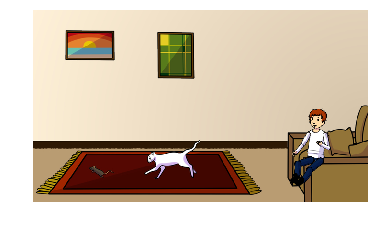

In [115]:
img_path, question, answer = qa.iloc[i][['img_path', 'question', 'answer']]

print(f"{question}? {pred_answer.iloc[i]} ({answer})")
plt.imshow(plt.imread(img_path))
plt.axis('off')

i += 1

In [120]:
(pred_answer == qa.answer).sum() / len(qa)

0.096066666666666661

In [125]:
model.sess.run(model.local_init)

In [126]:
acc = model._batch(model.metrics['acc_default'], generator=lambda: generator(inputs, 64, split, labels=labels, mean=mean, std=std))

In [127]:
acc

[[0.46031746,
  0.46825397,
  0.49735451,
  0.53571427,
  0.52698416,
  0.52910054,
  0.52380955,
  0.52182537,
  0.53791887,
  0.54126984,
  0.54112554,
  0.55158728,
  0.55433458,
  0.55328798,
  0.55873019,
  0.56051588,
  0.56862748,
  0.56525576,
  0.56725144,
  0.56666666,
  0.56538171,
  0.56854254,
  0.57418907,
  0.57473546,
  0.57333332,
  0.57203907,
  0.57554382,
  0.57709754,
  0.57799673,
  0.57883596,
  0.58125001,
  0.5794251,
  0.57966763,
  0.57894737,
  0.5796501,
  0.58210289,
  0.58616185,
  0.5819568,
  0.580033,
  0.58021712,
  0.58235294,
  0.58208954,
  0.57997012,
  0.57977366,
  0.57708782,
  0.57905757,
  0.57991803,
  0.58007354,
  0.57727569,
  0.57619506,
  0.57578617,
  0.57446808,
  0.57592255,
  0.57465124,
  0.57663172,
  0.57739627,
  0.57729059,
  0.57801712,
  0.57926166,
  0.57912999,
  0.57795274,
  0.57708335,
  0.57673585,
  0.57766008,
  0.57656986,
  0.5777126,
  0.57809865,
  0.57847321,
  0.57766879,
  0.57665747,
  0.5761289,
  0.57539147,

In [62]:
i = -1

what is the girl playing with? no


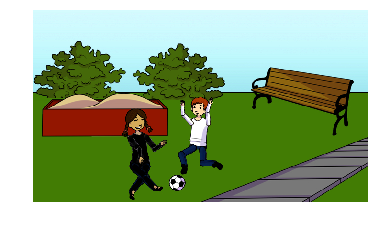

In [78]:
i += 1

img = plt.imread(test_qa.iloc[i].img_path)
print(f"{test_qa.iloc[i].question}? {answers[i]}")
plt.imshow(img)
plt.axis('off');

# Image Feature Extraction
List of pre-trained models [here][slim_models].

[slim_models]: https://github.com/tensorflow/models/tree/master/research/slim

In [2]:
import os

import sys
sys.path.append('/afs/csail.mit.edu/u/n/nhunt/github/models/research/slim/')

from nets.nasnet import nasnet

# resnet uses VGG preprocessing
from nets import resnet_v2
from preprocessing.vgg_preprocessing import _R_MEAN, _G_MEAN, _B_MEAN
rgb_means = np.array([_R_MEAN, _G_MEAN, _B_MEAN])

slim = tf.contrib.slim

In [3]:
%%bash
if [ ! -e pretrained ]; then
    mkdir pretrained
    cd pretrained

    mkdir resnet_50
    cd resnet_50
    wget -q http://download.tensorflow.org/models/resnet_v2_50_2017_04_14.tar.gz
    tar -xzf resnet_v2_50_2017_04_14.tar.gz
    rm resnet_v2_50_2017_04_14.tar.gz
    cd ..

    mkdir nasnet_large
    cd nasnet_large
    wget -q https://storage.googleapis.com/download.tensorflow.org/models/nasnet-a_large_04_10_2017.tar.gz
    tar -xzf nasnet-a_large_04_10_2017.tar.gz
    rm nasnet-a_large_04_10_2017.tar.gz
    cd ..

    mkdir nasnet_small
    cd nasnet_small
    wget -q https://storage.googleapis.com/download.tensorflow.org/models/nasnet-a_mobile_04_10_2017.tar.gz
    tar -xzf nasnet-a_mobile_04_10_2017.tar.gz
    rm nasnet-a_mobile_04_10_2017.tar.gz
fi

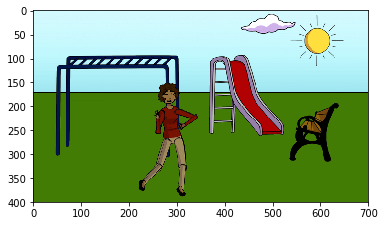

In [3]:
img = plt.imread('data/train/images/abstract_v002_train2015_000000000000.jpg')
img_shape = img.shape
plt.imshow(img)

In [4]:
imgs = np.array([img])

## ResNet-50

In [5]:
graph = tf.Graph()
with graph.as_default():
    img_p = tf.placeholder(tf.uint8, (None, *img_shape))

    # for VGG-style preprocessing, subtract RGB means and convert to float
    # (note that this doesn't put the pixels into [0, 1])
    processed_img = tf.cast(img_p, tf.float32) - rgb_means

    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(resnet_v2.resnet_arg_scope()):
        logits, endpoints = resnet_v2.resnet_v2_50(processed_img, num_classes=1001, is_training=False)

    init_fn = slim.assign_from_checkpoint_fn('pretrained/resnet_50/resnet_v2_50.ckpt',
                                             slim.get_model_variables('resnet_v2_50'))

sess = tf.Session(config=config, graph=graph)
init_fn(sess)

In [6]:
[op for op in graph.get_operations() if 'pool' in op.name.lower()]

[<tf.Operation 'resnet_v2_50/pool1/MaxPool' type=MaxPool>,
 <tf.Operation 'resnet_v2_50/block1/unit_3/bottleneck_v2/shortcut/MaxPool' type=MaxPool>,
 <tf.Operation 'resnet_v2_50/block2/unit_4/bottleneck_v2/shortcut/MaxPool' type=MaxPool>,
 <tf.Operation 'resnet_v2_50/block3/unit_6/bottleneck_v2/shortcut/MaxPool' type=MaxPool>,
 <tf.Operation 'resnet_v2_50/pool5/reduction_indices' type=Const>,
 <tf.Operation 'resnet_v2_50/pool5' type=Mean>]

In [7]:
ret = sess.run('resnet_v2_50/block3/unit_6/bottleneck_v2/shortcut/MaxPool:0', {img_p: imgs})
ret.shape

(1, 13, 22, 1024)

In [8]:
13 * 22 * 1024, np.array([img_shape[:-1]]) / np.array([13, 22]) # about 2 ** 5

(292864, array([[ 30.76923077,  31.81818182]]))

In [31]:
batch_size = 64

for split in ['train', 'val', 'test']:
    img_dir = f"data/{split}/images/"
    img_files = [f"{img_dir}/{img}" for img in os.listdir(img_dir)]

    idx = range(len(img_files))
    img_features = []

    i = 0
    file_number = 0
    for batch in tnrange(int(np.ceil(len(img_files) / batch_size))):
        batch_fnames = img_files[batch * batch_size : (batch + 1) * batch_size]
        batch_imgs = np.stack([plt.imread(fname) for fname in batch_fnames])
        img_features.append(
            sess.run('resnet_v2_50/block3/unit_6/bottleneck_v2/shortcut/MaxPool:0', {img_p: batch_imgs})
        )

        i += 1
        if i % 10 == 0:
            img_features = np.concatenate(img_features)
            with open(f'/cluster/nhunt/img_features/{split}/features{file_number}.npy', 'wb') as f:
                np.save(f, img_features)

            i = 0
            img_features = []
            file_number += 1

    # write out the last features, if they weren't already
    if i % 10 != 0:
        img_features = np.concatenate(img_features)
        with open(f'/cluster/nhunt/img_features/{split}/features{file_number}.npy', 'wb') as f:
            np.save(f, img_features)

A Jupyter Widget

## NasNet

In [33]:
graph = tf.Graph()
with graph.as_default():
    # Create the model, use the default arg scope to configure the batch norm parameters.
    img_p = tf.placeholder(tf.uint8, (None, *img_shape))

    # for Inception-style preprocessing, convert image to [0, 1]
    # then do 2 * (img - 0.5) (so img is in [-1, 1])
    processed_img = tf.image.convert_image_dtype(img_p, tf.float32)
    processed_img = 2 * (processed_img - 0.5)

    with slim.arg_scope(nasnet.nasnet_mobile_arg_scope()):
        logits, endpoints = nasnet.build_nasnet_mobile(processed_img, num_classes=1, is_training=False)

    init_fn = slim.assign_from_checkpoint_fn('pretrained/nasnet_small/model.ckpt.index',
                                            slim.get_model_variables())

sess = tf.Session(config=config, graph=graph)
init_fn(sess)

NotFoundError: Tensor name "cell_4/comb_iter_0/right/bn_sep_3x3_1/gamma" not found in checkpoint files pretrained/nasnet_small/model.ckpt.index
	 [[Node: save/RestoreV2_439 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2_439/tensor_names, save/RestoreV2_439/shape_and_slices)]]
	 [[Node: save/RestoreV2_317/_1597 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_3852_save/RestoreV2_317", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'save/RestoreV2_439', defined at:
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-f291af836bf4>", line 15, in <module>
    slim.get_model_variables())
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 659, in assign_from_checkpoint_fn
    saver = tf_saver.Saver(var_list, reshape=reshape_variables)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1218, in __init__
    self.build()
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1227, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1263, in _build
    build_save=build_save, build_restore=build_restore)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 751, in _build_internal
    restore_sequentially, reshape)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 427, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 267, in restore_op
    [spec.tensor.dtype])[0])
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1021, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Tensor name "cell_4/comb_iter_0/right/bn_sep_3x3_1/gamma" not found in checkpoint files pretrained/nasnet_small/model.ckpt.index
	 [[Node: save/RestoreV2_439 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2_439/tensor_names, save/RestoreV2_439/shape_and_slices)]]
	 [[Node: save/RestoreV2_317/_1597 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_3852_save/RestoreV2_317", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [17]:
endpoints

{'Cell_0': <tf.Tensor 'cell_0/cell_output/concat:0' shape=(?, 50, 88, 264) dtype=float32>,
 'Cell_1': <tf.Tensor 'cell_1/cell_output/concat:0' shape=(?, 50, 88, 264) dtype=float32>,
 'Cell_10': <tf.Tensor 'cell_10/cell_output/concat:0' shape=(?, 13, 22, 1056) dtype=float32>,
 'Cell_11': <tf.Tensor 'cell_11/cell_output/concat:0' shape=(?, 13, 22, 1056) dtype=float32>,
 'Cell_2': <tf.Tensor 'cell_2/cell_output/concat:0' shape=(?, 50, 88, 264) dtype=float32>,
 'Cell_3': <tf.Tensor 'cell_3/cell_output/concat:0' shape=(?, 50, 88, 264) dtype=float32>,
 'Cell_4': <tf.Tensor 'cell_4/cell_output/concat:0' shape=(?, 25, 44, 528) dtype=float32>,
 'Cell_5': <tf.Tensor 'cell_5/cell_output/concat:0' shape=(?, 25, 44, 528) dtype=float32>,
 'Cell_6': <tf.Tensor 'cell_6/cell_output/concat:0' shape=(?, 25, 44, 528) dtype=float32>,
 'Cell_7': <tf.Tensor 'cell_7/cell_output/concat:0' shape=(?, 25, 44, 528) dtype=float32>,
 'Cell_8': <tf.Tensor 'cell_8/cell_output/concat:0' shape=(?, 13, 22, 1056) dtype=fl

In [18]:
sess = tf.Session(config=config, graph=graph)

In [19]:
saver = tf.train.Saver()

In [14]:
ret = sess.run(endpoints['Cell_3'], {img_p: batch_imgs})

FailedPreconditionError: Attempting to use uninitialized value cell_3/comb_iter_0/left/separable_5x5_1/depthwise_weights
	 [[Node: cell_3/comb_iter_0/left/separable_5x5_1/depthwise_weights/read = Identity[T=DT_FLOAT, _class=["loc:@cell_3/comb_iter_0/left/separable_5x5_1/depthwise_weights"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](cell_3/comb_iter_0/left/separable_5x5_1/depthwise_weights)]]
	 [[Node: cell_3/cell_output/concat/_7 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1686_cell_3/cell_output/concat", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'cell_3/comb_iter_0/left/separable_5x5_1/depthwise_weights/read', defined at:
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-12e27da17793>", line 12, in <module>
    logits, endpoints = nasnet.build_nasnet_mobile(processed_img, num_classes=1, is_training=False)
  File "/afs/csail.mit.edu/u/n/nhunt/github/models/research/slim/nets/nasnet/nasnet.py", line 370, in build_nasnet_mobile
    final_endpoint=final_endpoint)
  File "/afs/csail.mit.edu/u/n/nhunt/github/models/research/slim/nets/nasnet/nasnet.py", line 486, in _build_nasnet_base
    cell_num=true_cell_num)
  File "/afs/csail.mit.edu/u/n/nhunt/github/models/research/slim/nets/nasnet/nasnet_utils.py", line 326, in __call__
    stride, original_input_left)
  File "/afs/csail.mit.edu/u/n/nhunt/github/models/research/slim/nets/nasnet/nasnet_utils.py", line 352, in _apply_conv_operation
    net = _stacked_separable_conv(net, stride, operation, filter_size)
  File "/afs/csail.mit.edu/u/n/nhunt/github/models/research/slim/nets/nasnet/nasnet_utils.py", line 183, in _stacked_separable_conv
    stride=stride)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 181, in func_with_args
    return func(*args, **current_args)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 2502, in separable_convolution2d
    outputs = layer.apply(inputs)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 671, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 559, in __call__
    self.build(input_shapes[0])
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/layers/convolutional.py", line 950, in build
    dtype=self.dtype)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 458, in add_variable
    trainable=trainable and self.trainable)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1203, in get_variable
    constraint=constraint)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1092, in get_variable
    constraint=constraint)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 417, in get_variable
    return custom_getter(**custom_getter_kwargs)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1539, in layer_variable_getter
    return _model_variable_getter(getter, *args, **kwargs)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1531, in _model_variable_getter
    custom_getter=getter, use_resource=use_resource)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 181, in func_with_args
    return func(*args, **current_args)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 262, in model_variable
    use_resource=use_resource)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 181, in func_with_args
    return func(*args, **current_args)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 217, in variable
    use_resource=use_resource)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 394, in _true_getter
    use_resource=use_resource, constraint=constraint)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 805, in _get_single_variable
    constraint=constraint)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 213, in __init__
    constraint=constraint)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 356, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 125, in identity
    return gen_array_ops.identity(input, name=name)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2071, in identity
    "Identity", input=input, name=name)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value cell_3/comb_iter_0/left/separable_5x5_1/depthwise_weights
	 [[Node: cell_3/comb_iter_0/left/separable_5x5_1/depthwise_weights/read = Identity[T=DT_FLOAT, _class=["loc:@cell_3/comb_iter_0/left/separable_5x5_1/depthwise_weights"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](cell_3/comb_iter_0/left/separable_5x5_1/depthwise_weights)]]
	 [[Node: cell_3/cell_output/concat/_7 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1686_cell_3/cell_output/concat", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [105]:
sess = tf.Session(config=config)
saver = tf.train.Saver()

In [106]:
saver.restore(sess, 'pretrained/nasnet_small/model.ckpt.index')

NotFoundError: Tensor name "is_training" not found in checkpoint files pretrained/nasnet_small/model.ckpt.index
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_BOOL], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]
	 [[Node: save/Assign/_2 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_7_save/Assign", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'save/RestoreV2', defined at:
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-105-cd262bbf92eb>", line 2, in <module>
    saver = tf.train.Saver()
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1218, in __init__
    self.build()
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1227, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1263, in _build
    build_save=build_save, build_restore=build_restore)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 751, in _build_internal
    restore_sequentially, reshape)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 427, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 267, in restore_op
    [spec.tensor.dtype])[0])
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1021, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Tensor name "is_training" not found in checkpoint files pretrained/nasnet_small/model.ckpt.index
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_BOOL], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]
	 [[Node: save/Assign/_2 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_7_save/Assign", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


# VQA TFRecords

In [24]:
train_qa = pd.read_hdf('data/train/qa.h5')
train_qa.head()

,img_path,answer,choices,question,objects,scene_type
0,data/train/images/abstract_v002_train2015_0000...,tan,"[1, 3, brown, wildlife, not having tv, yellow,...",what color is the ladies pants,"[[Doll02, 289, 242, 2, 1, -1], [sun, 594, 64, ...",Park-XinleiSubset
1,data/train/images/abstract_v002_train2015_0000...,monkey bars,"[get warm, yes, playful, pug, red, fitness sys...",how is the equipments with bars called,"[[Doll02, 289, 242, 2, 1, -1], [sun, 594, 64, ...",Park-XinleiSubset
2,data/train/images/abstract_v002_train2015_0000...,no,"[1, csi, real, n, red, solid, blocks and car, ...",is the bench a toy,"[[Doll02, 289, 242, 2, 1, -1], [sun, 594, 64, ...",Park-XinleiSubset
3,data/train/images/abstract_v002_train2015_0000...,yes,"[1, 3, idk, no, 2, red, skinny, blue, yes, hin...",is the woman on the couch sporting white hair,"[[Doll08, 585, 205, 2, 0, -1], [Rat, 196, 364,...",Living-XinleiSubset
4,data/train/images/abstract_v002_train2015_0000...,sitting,"[4, yellow, no, 2, reading, holding table, bar...",what is the woman doing,"[[Doll08, 585, 205, 2, 0, -1], [Rat, 196, 364,...",Living-XinleiSubset


# Batch Norm w/ Dense Error

In [20]:
layers = [
    [LSTMLayer(10, scope='lstm1'), LSTMLayer(10, scope='lstm2')],
    DenseLayer(10)
]

layers = add_implied_layers(layers)

n_features = 10
n_timesteps = 3

input_data = {
    'in1': ((n_timesteps, n_features), 'float32'),
    'in2': ((n_timesteps, n_features), 'float32'),
}

In [21]:
model = CNN(input_data, layers, config=config, record=False, n_classes=2)

In [22]:
batch_size = 5
ins = np.random.rand(batch_size, n_timesteps, n_features)
labels = np.random.randint(2, size=batch_size)

In [23]:
fd = model._get_feed_dict({'in1': ins, 'in2': ins}, {'default': labels})
fd['is_training:0'] = True

In [24]:
model.sess.run(model.loss_op, fd)

0.53910047

In [25]:
model.sess.run(model.train_op, fd)

In [26]:
model.sess.run([model.loss_op, model.train_op], fd)

[0.51347363, None]

In [ ]:
tf.reset_default_graph()

inp1_length = 5
inp2_length = 8
inp2_n_features = 10

vocab_size = 12
embed_size = 20


inp1 = tf.placeholder(tf.int32, (None, inp1_length))
inp2 = tf.placeholder(tf.float32, (None, inp2_length, inp2_n_features))
labels = tf.placeholder(tf.int32, (None,))

embed = tf.nn.embedding_lookup(tf.get_variable('embedding', (vocab_size, embed_size)), inp1)

with tf.variable_scope('lstm1'):
    _, state1 = tf.nn.dynamic_rnn(tf.nn.rnn_cell.LSTMCell(25), embed, dtype=tf.float32)

with tf.variable_scope('lstm2'):
    _, state2 = tf.nn.dynamic_rnn(tf.nn.rnn_cell.LSTMCell(27), inp2, dtype=tf.float32)

merged = tf.concat((state1.c, state2.c), axis=-1)
dense = tf.layers.dense(merged, 30, activation=tf.nn.relu)

logits = tf.layers.dense(dense, 2)

loss_op = tf.losses.sparse_softmax_cross_entropy(labels, logits)
train_op = tf.train.AdamOptimizer().minimize(loss_op)

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 5
feed_dict = {
    inp1: np.random.randint(vocab_size, size=(batch_size, inp1_length)),
    inp2: np.random.rand(batch_size, inp2_length, inp2_n_features),
    labels: np.random.randint(2, size=batch_size)
}

In [ ]:
sess.run(loss_op, feed_dict)

In [ ]:
sess.run(train_op, feed_dict)

In [ ]:
sess.run([loss_op, train_op], feed_dict)